<a href="https://www.kaggle.com/code/akscent/ods-boosting?scriptVersionId=150530573" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install shap optuna -q > installer_log.txt
import cudf
# %load_ext cudf.pandas 
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import os
import shap
import optuna
import copy
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, log_loss
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingClassifier
from optuna.integration import CatBoostPruningCallback

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading Train Data

In [30]:
pr_train = pd.read_csv('/kaggle/input/ods-huawei/feature_profiler_train.csv')
train = pd.read_csv('/kaggle/input/ods-huawei/new_train.csv')
f_train = pd.read_csv('/kaggle/input/ods-huawei/feature_train.csv')
p_train = pd.read_csv('/kaggle/input/ods-huawei/train_proba_tf.csv')
lstm_train = pd.read_csv('/kaggle/input/ods-huawei/lstm_features_train.csv')
train = pd.concat([f_train['rate'], train, p_train, train, pr_train, lstm_train], axis=1)
train = train.loc[:,~train.columns.duplicated()]
non_numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns

y = train['rate']
X = train[non_numeric_columns].drop(columns = 'rate')

In [3]:
# X.columns

list_columns = ['MOOD_1', 'MOOD_0', 'MOOD_2', 'Num_NOUN', 'Num_ADJ', 'EMOTION_2',
       'TOXIC_0', 'spelling_quality_score', 'EMOTION_1', 'TOXIC_1',
       'EMOTION_4', 'EMOTION_5', 'LABEL_10', 'Num_VERB', 'sentences_count',
       'LABEL_15', 'chars_excl_spaces_count', 'LABEL_2', 'LABEL_5',
       'EMOTION_0', 'LABEL_8', 'non_alpha_numeric_count', 'LABEL_9',
       'EMOTION_6', 'LABEL_11', 'characters_count', 'LABEL_17', 'LABEL_1',
       'LABEL_13', 'LABEL_14', 'LABEL_18', 'LABEL_95', 'LABEL_0',
       'noun_phase_count', 'LABEL_6', 'LABEL_103', 'LABEL_127', 'LABEL_210',
       'LABEL_119', 'LABEL_177', 'LABEL_118', 'LABEL_89', 'LABEL_20',
       'LABEL_100', 'LABEL_97', 'LABEL_334', 'LABEL_247', 'LABEL_215',
       'LABEL_169', 'num_unique_words', '1 star', '2 stars', '3 stars',
       '4 stars', '5 stars', 'spaces_count', 'count_words', 'duplicates_count',
       'emoji_count', 'whole_numbers_count', 'alpha_numeric_count',
       'punctuations_count', 'stop_words_count', 'dates_count',
       'sentiment_polarity_score', 'sentiment_subjectivity_score',
       'Star_LSTM_1', 'Star_LSTM_2', 'Star_LSTM_3', 'Star_LSTM_4',
       'Star_LSTM_5']

# Catboost

In [36]:

def fit_catboost(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val
    train_dataset = Pool(data=X_train, label=y_train)
    eval_dataset = Pool(data=X_val, label=y_val)

    param = {
        'iterations' : 3000,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 50),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.8),
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
        "depth": trial.suggest_int("depth", 3, 9),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "eval_metric": "Accuracy",
    }

    pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
    clf = CatBoostClassifier(**param, task_type="CPU", early_stopping_rounds=1000, random_seed=42)
    clf.fit(train_dataset, eval_set=eval_dataset, verbose=500, callbacks=[pruning_callback], plot=False)
    pruning_callback.check_pruned()
    y_pred = clf.predict(X_val)
    return clf, y_pred


def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores, models = [], []
    
    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]
        model, y_pred = fit_catboost(trial, train_data, valid_data)
        scores.append(f1_score(y_pred, valid_data[1], average='weighted'))
        models.append(model)
        break
        
    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result
    


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,
               n_trials=30,
               n_jobs = -1,
               show_progress_bar=True)

  0%|          | 0/300 [00:00<?, ?it/s]

0:	learn: 0.5847496	test: 0.5960115	best: 0.5960115 (0)	total: 859ms	remaining: 42m 57s
0:	learn: 0.3913535	test: 0.3991475	best: 0.3991475 (0)	total: 1.11s	remaining: 55m 31s
0:	learn: 0.3871507	test: 0.4045011	best: 0.4045011 (0)	total: 2.14s	remaining: 1h 47m
0:	learn: 0.5770514	test: 0.5736020	best: 0.5736020 (0)	total: 2.25s	remaining: 1h 52m 18s
500:	learn: 0.5953719	test: 0.6025905	best: 0.6034128 (469)	total: 6m 52s	remaining: 34m 17s
500:	learn: 0.4237724	test: 0.4309531	best: 0.4324990 (469)	total: 8m 27s	remaining: 42m 10s
1000:	learn: 0.5990954	test: 0.6069079	best: 0.6075247 (961)	total: 13m 23s	remaining: 26m 44s
1000:	learn: 0.4344956	test: 0.4323949	best: 0.4360384 (681)	total: 16m 19s	remaining: 32m 35s
500:	learn: 0.4314505	test: 0.4374140	best: 0.4381016 (482)	total: 18m 59s	remaining: 1h 34m 44s
500:	learn: 0.5968339	test: 0.6027961	best: 0.6036184 (471)	total: 19m 5s	remaining: 1h 35m 11s
1500:	learn: 0.6025905	test: 0.6097862	best: 0.6108141 (1325)	total: 19m 59s	

In [11]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 0.7231390396332701
  Params: 
    learning_rate: 0.0031241744378306684
    l2_leaf_reg: 21
    colsample_bylevel: 0.4661705497287475
    auto_class_weights: None
    depth: 6
    boosting_type: Ordered
    bootstrap_type: MVS


In [40]:
def train_catboost(X, y, params):
    n_splits = 2
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        X_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
        X_val, y_val = X.iloc[valid_idx, :], y.iloc[valid_idx]

        train_dataset = Pool(data=X_train, label=y_train)
        eval_dataset = Pool(data=X_val, label=y_val)

        clf = CatBoostClassifier(**params, task_type="CPU", iterations=5000,
                                early_stopping_rounds=2000, random_seed=42)
        clf.fit(train_dataset, eval_set=eval_dataset, verbose=500, plot=False)

        y_pred = clf.predict(X_val)
        scores.append(f1_score(y_pred, y_val, average='weighted'))
        models.append(clf)

    mean_score = np.mean(scores)
    best_model = models[np.argmax(scores)]

    return mean_score, best_model


params = {
    "learning_rate": 0.0031241744378306684,
    "l2_leaf_reg": 21,
    "colsample_bylevel": 0.4661705497287475,
    "auto_class_weights": None,
    "depth": 6,
    "boosting_type": "Ordered",
    "eval_metric": "Accuracy",
}

mean_score, best_model = train_catboost(X, y, params)
print("Mean F1 Score:", mean_score)

0:	learn: 0.6621299	test: 0.6646793	best: 0.6646793 (0)	total: 210ms	remaining: 17m 30s
500:	learn: 0.7036184	test: 0.7052632	best: 0.7053454 (492)	total: 1m 43s	remaining: 15m 30s
1000:	learn: 0.7077303	test: 0.7076069	best: 0.7076891 (994)	total: 3m 26s	remaining: 13m 44s
1500:	learn: 0.7099507	test: 0.7092516	best: 0.7094984 (1462)	total: 5m 9s	remaining: 12m 1s
2000:	learn: 0.7113076	test: 0.7112253	best: 0.7113076 (1934)	total: 6m 54s	remaining: 10m 20s
2500:	learn: 0.7128701	test: 0.7125411	best: 0.7126645 (2376)	total: 8m 38s	remaining: 8m 37s
3000:	learn: 0.7140214	test: 0.7131990	best: 0.7135691 (2808)	total: 10m 21s	remaining: 6m 54s
3500:	learn: 0.7157484	test: 0.7136513	best: 0.7136924 (3320)	total: 12m 5s	remaining: 5m 10s
4000:	learn: 0.7173109	test: 0.7131990	best: 0.7136924 (3320)	total: 13m 49s	remaining: 3m 27s
4500:	learn: 0.7189145	test: 0.7135691	best: 0.7136924 (3320)	total: 15m 33s	remaining: 1m 43s
4999:	learn: 0.7199424	test: 0.7136924	best: 0.7139391 (4714)	to

In [44]:
best_model.save_model('catboost_model.cbm')

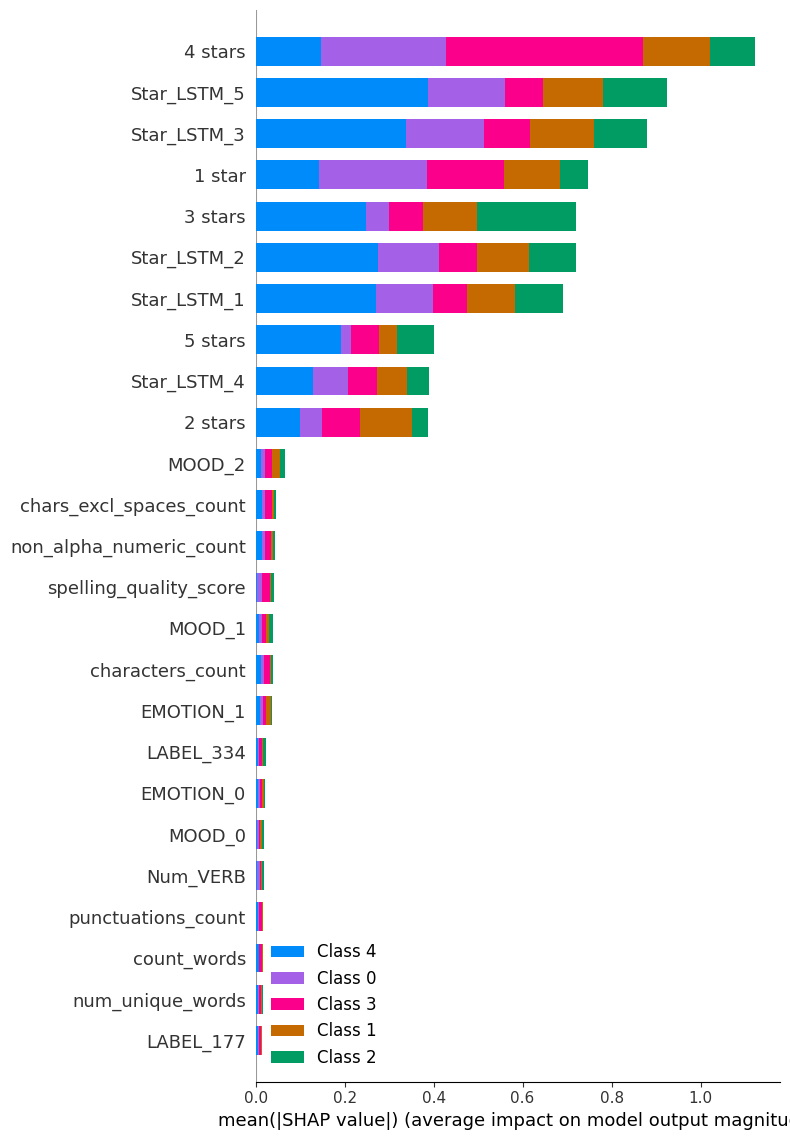

In [43]:
shap.initjs()

explainer = shap.TreeExplainer(best_model)

train_dataset = Pool(data=X, label=y)
shap_values = explainer.shap_values(train_dataset)

shap.summary_plot(shap_values, X, max_display=25)

In [ ]:
feature_list = ["5 stars", "1 star", "4 stars", "3 stars", "2 stars", "MOOD_2", "characters_count", "MOOD_1", "MOOD_0", 
"TOXIC_1", "TOXIC_0", "chars_excl_spaces_count", "non_alpha_numeric_count", "spelling_quality_score",
"num_unique_words", "LABEL_103", "LABEL_119", "LABEL_1", "LABEL_95", "EMOTION_2", "EMOTION_4", "noun_phase_count"]

mean_score_1, best_model_1 = train_catboost(X[feature_list], y, params)
print("Mean F1 Score:", mean_score_1)

In [3]:
feature_list = ["5 stars", "1 star", "4 stars", "3 stars", "2 stars", "MOOD_2", "characters_count", "MOOD_1", "MOOD_0", 
"TOXIC_1", "TOXIC_0"]

mean_score_2, best_model_2 = train_catboost(X[feature_list], y, params)
print("Mean F1 Score:", mean_score_2)

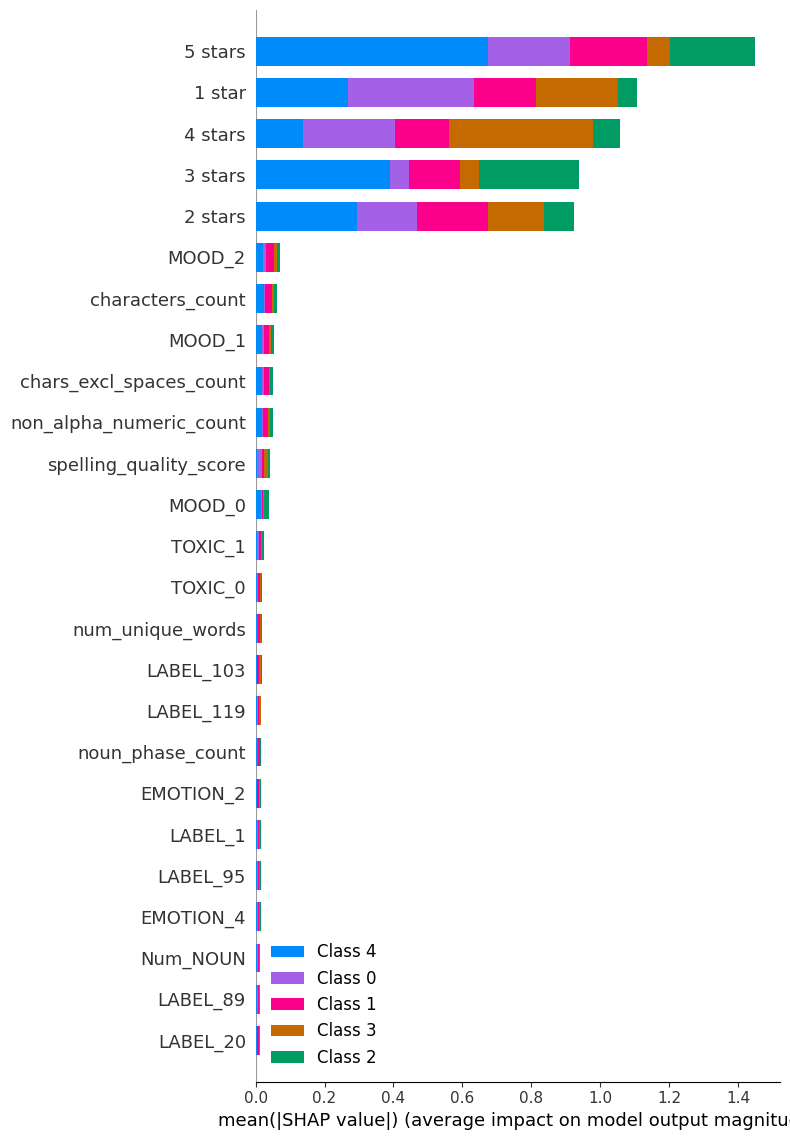

In [16]:

shap.initjs()

explainer = shap.TreeExplainer(models[-1])

train_dataset = Pool(data=X, label=y)
shap_values = explainer.shap_values(train_dataset)

shap.summary_plot(shap_values, X, max_display=25)

# XGBoost

In [5]:



def objective(trial):
    global clf

    param_grid = {
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 12000),
        'lambda': trial.suggest_float('lambda', 1e-3, 1e3),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'min_child_weight': trial.suggest_int('min_child_weight', 300, 2000),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.10, 0.5),
    }

    clf = XGBClassifier(objective='multi:softprob', use_label_encoder=False,
                        num_class=5, gpu_id=0, tree_method='gpu_hist', **param_grid)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1s = []

    for train_idx, valid_idx in kf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        X_train = np.log(X_train + 1)
        X_valid = np.log(X_valid + 1)
        X_train = RobustScaler().fit_transform(X_train)
        X_valid = RobustScaler().fit_transform(X_valid)

        pruning_callback = XGBoostPruningCallback(trial, 'validation_1-mlogloss')
        clf.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                eval_metric='mlogloss', verbose=3000, callbacks=[pruning_callback])

        y_pred = clf.predict(X_valid)
        f1 = f1_score(y_valid, y_pred, average='weighted')
        f1s.append(f1)

    return np.mean(f1s)

def callback(study, trial):
    global best_classifier
    if study.best_trial == trial:
        best_classifier = clf

train_time = 3 * 60 * 60  # 3 h * 60 m * 60 s

study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, timeout=train_time, callbacks=[callback])

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[0]	validation_0-mlogloss:1.51968	validation_1-mlogloss:1.51947
[3000]	validation_0-mlogloss:0.57143	validation_1-mlogloss:0.75569
[5280]	validation_0-mlogloss:0.50862	validation_1-mlogloss:0.77316
[0]	validation_0-mlogloss:1.51945	validation_1-mlogloss:1.52023
[3000]	validation_0-mlogloss:0.57192	validation_1-mlogloss:0.75730
[5280]	validation_0-mlogloss:0.50911	validation_1-mlogloss:0.77244
[0]	validation_0-mlogloss:1.51948	validation_1-mlogloss:1.51961
[3000]	validation_0-mlogloss:0.57273	validation_1-mlogloss:0.74865
[5280]	validation_0-mlogloss:0.50962	validation_1-mlogloss:0.76543
[0]	validation_0-mlogloss:1.51936	validation_1-mlogloss:1.51944
[3000]	validation_0-mlogloss:0.57159	validation_1-mlogloss:0.75353
[5280]	validation_0-mlogloss:0.50865	validation_1-mlogloss:0.76916
[0]	validation_0-mlogloss:1.51906	validation_1-mlogloss:1.51990
[3000]	validation_0-mlogloss:0.57141	validation_1-mlogloss:0.75867
[5280]	validation_0-mlogloss:0.50848	validation_1-mlogloss:0.77506
[0]	valida

In [12]:


def train_model_with_cv(X, y, model_type, params, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1s = []
    best_f1 = 0
    best_model = None

    for train_idx, valid_idx in kf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

#         X_train = np.log(X_train + 1)
#         X_valid = np.log(X_valid + 1)
#         X_train = RobustScaler().fit_transform(X_train)
#         X_valid = RobustScaler().fit_transform(X_valid)

        if model_type == 'XGBClassifier':
            model = XGBClassifier(objective='multi:softprob', use_label_encoder=False,
                                  num_class=len(np.unique(y)), gpu_id=0, tree_method='gpu_hist', **params)
            model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_metric='mlogloss', verbose=1000)
            
        elif model_type == 'LGBM':
            model = LGBMClassifier(objective='multi:softprob',
                                  num_class=len(np.unique(y)), **params);
            model.fit(X_train, y_train, verbose=1000)
            
        elif model_type == 'CatboostClassifer':
            train_dataset = Pool(data=X_train, label=y_train)
            eval_dataset = Pool(data=X_valid, label=y_valid)
            model = CatBoostClassifier(**params);
            model.fit(train_dataset, eval_set=eval_dataset, verbose=1000, plot=False)

        y_pred = model.predict(X_valid)
        f1 = f1_score(y_valid, y_pred, average='weighted')
        f1s.append(f1)

        if f1 > best_f1:
            best_f1 = f1
            best_model = copy.deepcopy(model)

    average_f1 = np.mean(f1s)
    return average_f1, best_model

model_type = 'XGBClassifier'
best_params = {
    'max_depth': 13,
    'subsample': 0.692900501887427,
    'n_estimators': 10000,
    'lambda': 27.658047515722444,
    'learning_rate': 0.010222318009404707,
    'min_child_weight': 1003,
    'colsample_bytree': 0.17027213976623792,
    'early_stopping_rounds': 3000,
}
average_f1, best_xgb_model = train_model_with_cv(X, y, model_type, best_params)
print('Average F1 score on cross-validation: ', average_f1)

In [34]:
best_xgb_model.save_model('xgboost_model.cbm')

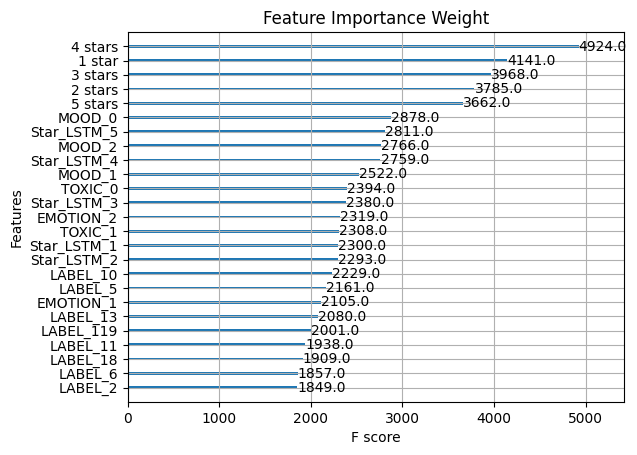

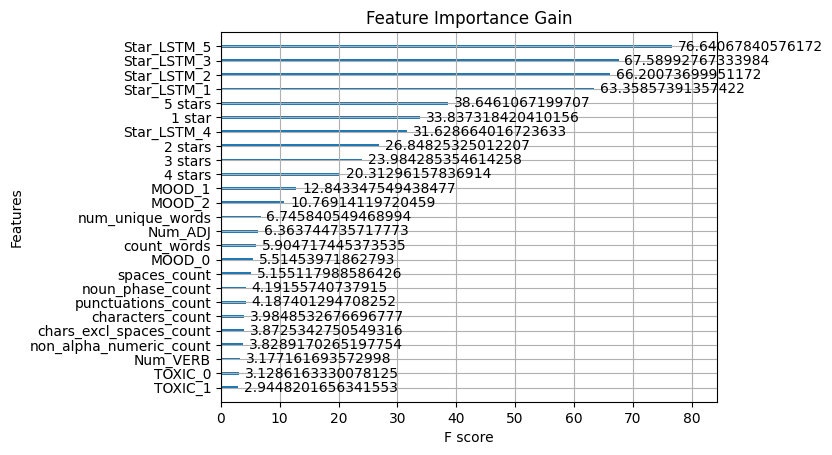

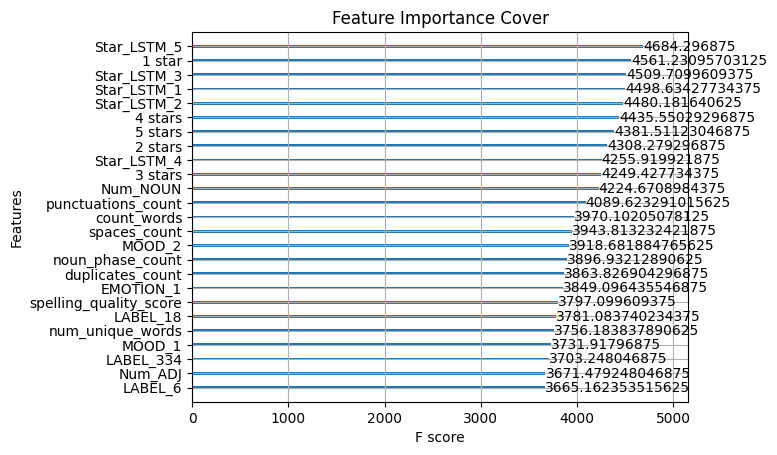

In [32]:
xgb.plot_importance(best_xgb_model, title='Feature Importance Weight', max_num_features=25)
xgb.plot_importance(best_xgb_model, importance_type='gain', title='Feature Importance Gain', max_num_features=25)
xgb.plot_importance(best_xgb_model, importance_type='cover', title='Feature Importance Cover', max_num_features=25);

In [33]:
# важность фич по весу
feature_importance_weight = best_xgb_model.get_booster().get_score(importance_type='weight')
top_features_weight = [feature for feature, _ in sorted(feature_importance_weight.items(), key=lambda x: x[1], reverse=True)[:25]]

# важность фич по gain
feature_importance_gain = best_xgb_model.get_booster().get_score(importance_type='gain')
top_features_gain = [feature for feature, _ in sorted(feature_importance_gain.items(), key=lambda x: x[1], reverse=True)[:25]]

# важность фич по покрытию
feature_importance_cover = best_xgb_model.get_booster().get_score(importance_type='cover')
top_features_cover = [feature for feature, _ in sorted(feature_importance_cover.items(), key=lambda x: x[1], reverse=True)[:25]]
unique_top_features = list(set(top_features_weight + top_features_gain + top_features_cover))
print(unique_top_features)


['MOOD_1', 'TOXIC_1', 'MOOD_0', 'Num_ADJ', 'noun_phase_count', 'characters_count', 'Star_LSTM_4', 'chars_excl_spaces_count', 'Star_LSTM_3', '5 stars', 'LABEL_18', 'Num_NOUN', 'LABEL_11', 'MOOD_2', 'num_unique_words', 'LABEL_6', 'count_words', 'punctuations_count', 'duplicates_count', 'Num_VERB', '1 star', 'spelling_quality_score', 'EMOTION_2', 'LABEL_10', 'LABEL_119', 'non_alpha_numeric_count', '3 stars', 'LABEL_334', 'Star_LSTM_2', 'Star_LSTM_5', '2 stars', 'LABEL_5', 'Star_LSTM_1', 'TOXIC_0', 'LABEL_2', 'EMOTION_1', 'spaces_count', 'LABEL_13', '4 stars']


# LGBM

In [54]:


def objective(trial, X, y):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'n_estimators': trial.suggest_int('n_estimators', 2000, 5000),
        'device_type': 'gpu',
        'metric': 'multi_logloss',
        'min_child_weight': trial.suggest_int('min_child_weight', 300, 2000),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.10, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
    }

    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_idx, valid_idx in tqdm(kf.split(X), total=n_splits, desc='Training'):
        X_train, X_valid = X.iloc[train_idx, :], X.iloc[valid_idx, :]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        X_train.columns = X_train.columns.str.replace(' ', '_')
        X_valid.columns = X_valid.columns.str.replace(' ', '_')

        clf = lgb.LGBMClassifier(**params)
        clf.fit(X_train, y_train, verbose=0)
        y_pred = clf.predict(X_valid)
        f1 = f1_score(y_valid, y_pred, average='weighted')
        scores.append(f1)

    mean_score = sum(scores) / len(scores)

    return mean_score

study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)
best_lgbm_params = study.best_params
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Number of finished trials:  100
Best trial:
  Value: 0.6919139015908451
  Params: 
    n_estimators: 2264
    min_child_weight: 351
    colsample_bytree: 0.40874204382658685
    num_leaves: 23
    learning_rate: 0.010433728530130512


In [13]:

best_params = {
    'n_estimators': 3000,
    'min_child_weight': 351,
    'colsample_bytree': 0.40874204382658685,
    'num_leaves': 23,
    'learning_rate': 0.010433728530130512,
}

average_f1, best_lgbm_model = train_model_with_cv(X, y, model_type = 'LGBM', params = best_params)
print('Average F1 score on cross-validation: ', average_f1)

Average F1 score on cross-validation:  0.6915246317626262


In [15]:
best_lgbm_model.booster_.save_model('lgbm_model.txt')

# Loading Test Data

In [6]:
PATH = "/kaggle/input/ods-huawei/"
test_data = pd.read_csv(os.path.join(PATH, "test_cleaned.csv"))
adj_test_data = pd.read_csv(os.path.join(PATH, "adj_test_data.csv"))
add_feature = pd.read_csv(os.path.join(PATH, "test_proba_tf.csv"))
labels_test_data = pd.read_csv(os.path.join(PATH, "labels_test_data.csv"))
profiler_add_feature = pd.read_csv(os.path.join(PATH, "profiled_text_data_test.csv"))
mood_toxic_test = pd.read_csv(os.path.join(PATH, "mood_toxic_test.csv"))
lstm_proba_test = pd.read_csv(os.path.join(PATH, "lstm_features_test.csv"))

test = pd.concat([test_data, add_feature, adj_test_data, profiler_add_feature, mood_toxic_test, lstm_proba_test, labels_test_data], axis=1)

test = test.loc[:,~test.columns.duplicated()]
non_numeric_columns = test.select_dtypes(include=['float64', 'int64']).columns

X = test[non_numeric_columns]
X = X[list_columns]

In [25]:
lgbm = lgb.Booster(model_file=os.path.join(PATH, 'lgbm_model.txt'))
catboost = CatBoostClassifier()
catboost.load_model(os.path.join(PATH, 'catboost_model.cbm'))
xgboost = XGBClassifier()
xgboost.load_model(os.path.join(PATH, 'xgboos_model.cbm'))

def ensemble_predict(lgbm, catboost, xgboost, X):
    lgbm_pred = lgbm.predict(X, num_iteration=lgbm.best_iteration)
    catboost_pred = catboost.predict_proba(X)
    xgboost_pred = xgboost.predict_proba(X)

    ensemble_proba = np.mean([lgbm_pred, catboost_pred, xgboost_pred], axis=0)
    ensemble_pred = np.argmax(ensemble_proba, axis=1)

    return ensemble_pred

ensemble_pred = ensemble_predict(lgbm, catboost, xgboost, X)
ensemble_pred


array([4, 3, 4, ..., 4, 4, 3])

In [28]:
ensemble_pred = ensemble_pred + 1

4

In [29]:
sample_submission = pd.read_csv(os.path.join(PATH, "sample_submission.csv"))
sample_submission["rate"] = ensemble_pred
sample_submission.to_csv("submission.csv", index=False)

# Train confusion matrix

Classification Report for train dataset:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67      4765
           1       0.06      0.58      0.10       236
           2       0.59      0.51      0.55      7176
           3       0.47      0.60      0.53      7756
           4       0.92      0.84      0.88     28707

    accuracy                           0.73     48640
   macro avg       0.55      0.63      0.54     48640
weighted avg       0.78      0.73      0.75     48640



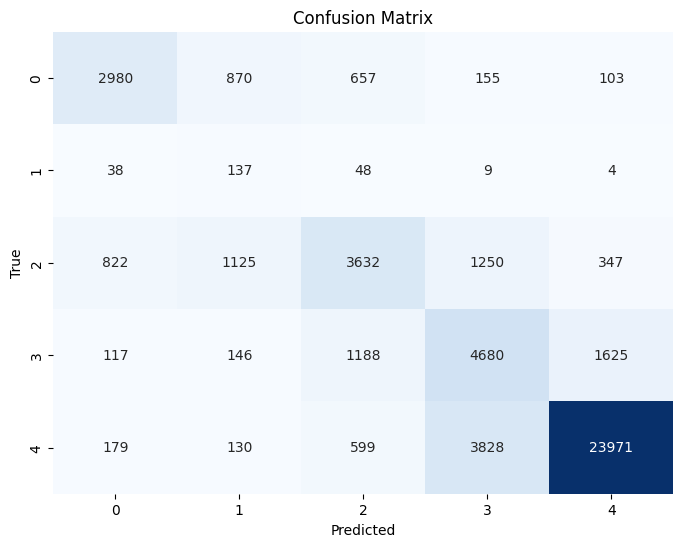

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_classification_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

ensemble_pred = ensemble_predict(lgbm, catboost, xgboost, X)
evaluate_classification_metrics(ensemble_pred, y, "train dataset")